In [1]:
from ss2hcsp.hcsp.simulator import SimInfo, exec_parallel, graph
from ss2hcsp.hcsp.hcsp import HCSPOutput

# HCSP简介

混成通讯顺序进程(Hybrid Communicating Sequential Processes, HCSP)是一个形式化建模语言，在通讯顺序进程(CSP)的基础上添加了由微分方程描述的连续演化和中断机制。在```ss2hcsp.hcsp.simulator```中提供了对HCSP进程的仿真功能。首先，我们定义一个简单的wrapper来调用仿真函数。

In [2]:
def run_processes(infos, num_io_events, *, output):
    list_infos = []
    for name, ps in infos.items():
        list_infos.append(SimInfo(name, ps, outputs=[HCSPOutput(var) for var in output]))
    res = exec_parallel(list_infos, num_io_events=num_io_events)
    events = [event['str'] for event in res['trace'] if event['str'] not in ('start', 'step')]
    return res, events

## 赋值和循环

首先，我们考虑一些单线程的例子。在HCSP中，wait(n)的含义是等待n秒（或其他时间单位）。一个简单的程序如下：

In [3]:
res, events = run_processes({
    'P0': "x := 1; wait(1); x := 0; wait(2); x := 2; wait(1);"
}, 10, output=["x"])

```run_processes```接受一个从进程名称到进程代码的字典，以及仿真的步数，然后返回两组数据：
1. ```res```包含了所有仿真产生的信息，可以使用```graph```函数画出每个进程变量的变化轨迹。
2. ```events```包含了仿真过程中发生的事件。

首先，我们看一下graph给出的结果：

In [4]:
res

{'time': 4,
 'trace': [{'type': 'start',
   'str': 'start',
   'id': 0,
   'time': 0,
   'ori_pos': {'P0': {'innerpos': ['p0'], 'procedure': [None]}},
   'infos': {'P0': {'callstack': {'innerpos': ['p0'], 'procedure': [None]},
     'statenum': 0}}},
  {'type': 'step',
   'str': 'step',
   'id': 1,
   'time': 0,
   'ori_pos': {'P0': {'innerpos': ['p0'], 'procedure': [None]}},
   'infos': {'P0': {'callstack': {'innerpos': ['p1'], 'procedure': [None]},
     'statenum': 1}}},
  {'type': 'delay',
   'delay_time': 1,
   'str': 'delay 1',
   'id': 2,
   'time': 0,
   'ori_pos': {'P0': {'innerpos': ['p1'], 'procedure': [None]}},
   'infos': {'P0': {'callstack': {'innerpos': ['p2'], 'procedure': [None]},
     'statenum': 1}}},
  {'type': 'step',
   'str': 'step',
   'id': 3,
   'time': 1,
   'ori_pos': {'P0': {'innerpos': ['p2'], 'procedure': [None]}},
   'infos': {'P0': {'callstack': {'innerpos': ['p3'], 'procedure': [None]},
     'statenum': 2}}},
  {'type': 'delay',
   'delay_time': 2,
   's

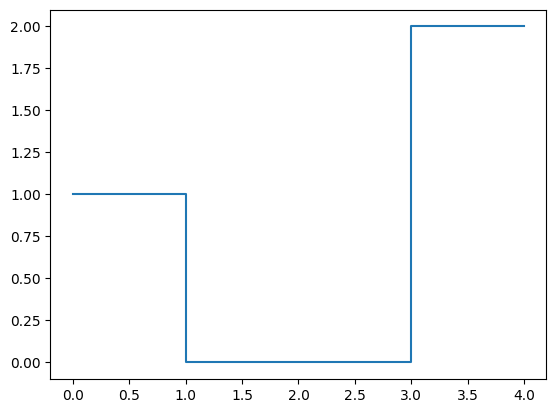

In [5]:
graph(res, 'P0')

这个图展示了$x$（唯一的变量）的值在0-1秒是1，在1-3秒是0，在3-4秒是2。对于这个例子，```events```记录了在执行过程中分别暂停了1, 2, 1秒：

In [6]:
events

['delay 1', 'delay 2', 'delay 1', 'deadlock']

下面，我们展示赋值和循环的使用。以下进程将$x$初始化为0，然后不断对$x$加2并等待1秒：

In [7]:
res, events = run_processes({
    'P0': "x := 0; {x := x + 2; wait(1);}*"
}, 10, output=["x"])

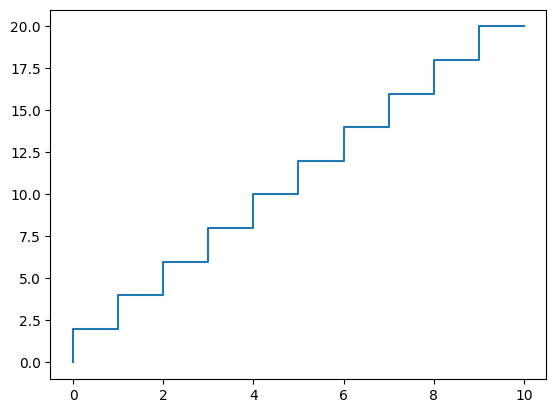

In [8]:
graph(res, 'P0')

## 微分方程

下面，我们展示微分方程的使用。一个微分方程语句$\langle \dot{x} = e \& B\rangle$表示：根据$x$的导数为$e$演化，直到系统状态离开由$B$指定的区域。例如，

In [9]:
res, events = run_processes({
    'P0': "x := 0; {x_dot = 2 & x < 10}"
}, 10, output=["x"])

该进程从$x$从0开始，以速度2上升，直到到达$x=10$。因此，该进程的执行时间应该为5秒钟：

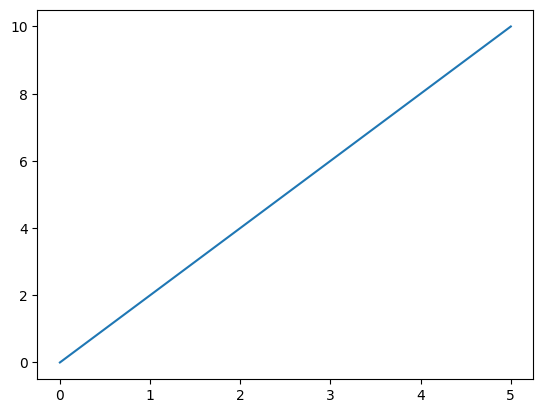

In [10]:
graph(res, 'P0')

```events```列表仅记录等待的时间：

In [11]:
events

['delay 5.0', 'deadlock']

合并循环和微分方程，我们可以构造一个具有锯齿形状演化的系统：

In [12]:
res, events = run_processes({
    'P0': "x := 0; {{x_dot = 1 & x < 1} {x_dot = -1 & x > 0}}*"
}, 10, output=["x"])

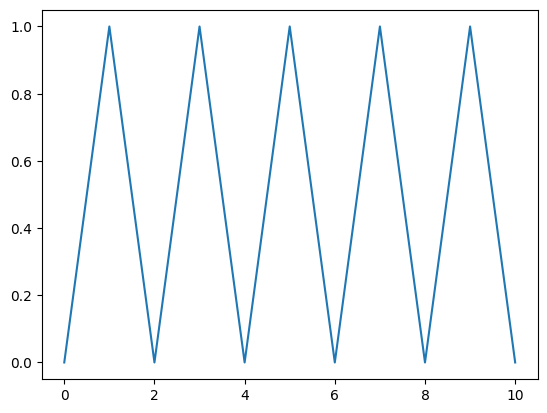

In [13]:
graph(res, 'P0')

微分方程可能有各种形式。例如，以下微分方程的行为是指数增长：

In [14]:
res, events = run_processes({
    'P0': "x := 1; {x_dot = 0.2 * x & x < 3}"
}, 10, output=["x"])

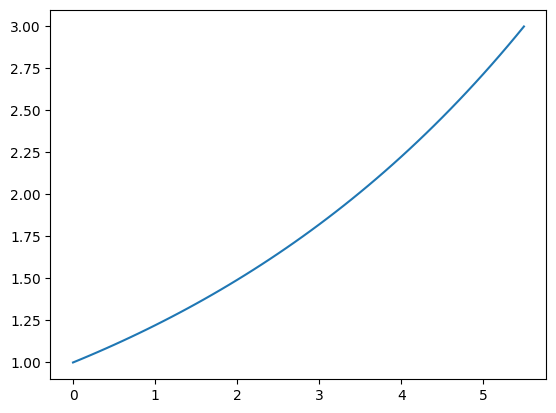

In [15]:
graph(res, 'P0')

我们可以在```res['times']```中读出整个仿真时间（在这里就是$x$到达3需要的时间）：

In [16]:
res['time']

5.493046902196262

此外，微分方程还允许多个变量同时变化。以下例子描述了加速度为常数的模型，在对汽车、列车等系统的建模时非常常见：

In [17]:
res, events = run_processes({
    'P0': "x := 0; v := 0; a := 1; {x_dot = v, v_dot = a & x < 10}"
}, 10, output=["x", "v", "a"])

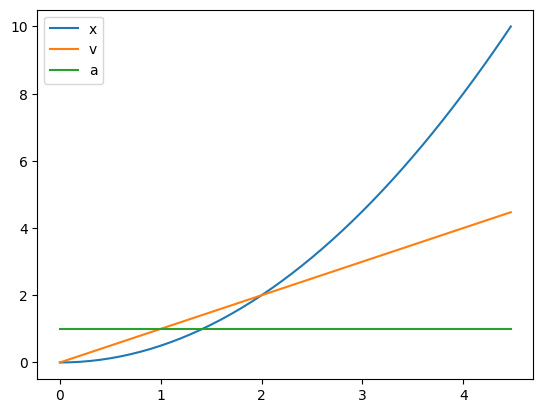

In [18]:
graph(res, 'P0', separate=False)

在该图中，同时展示了$x, v$和$a$随着时间的演变。我们也可以省略```separate=False```选项，使得```graph```函数输出3个图。

下面的例子建模一个旋转行为的系统。注意，我们使用$t$变量来控制执行时间：

In [19]:
res, events = run_processes({
    'P0': "x := 1; y := 0; t := 0; {x_dot = y, y_dot = -x, t_dot = 1 & t < 6.283}"
}, 10, output=["x", "y"])

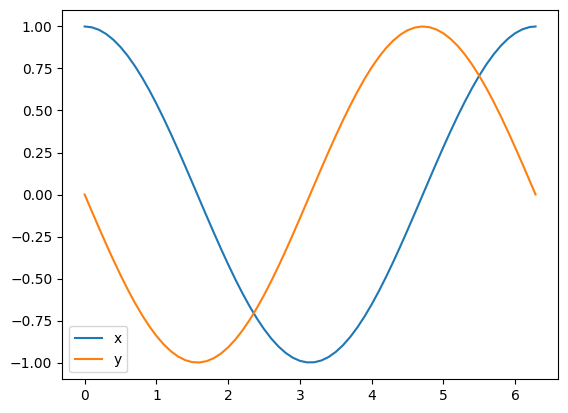

In [20]:
graph(res, 'P0', separate=False, variables=['x', 'y'])

## 通讯

CSP最显著的特征是允许多个进程以及进程之间的通讯。两个进程之间可以通过一个通道传递信息。设通道的名称为$ch$，那么$ch!e$表示将表达式$e$的值从通道$ch$发出，$ch?x$表示从通道$ch$接收一个值，并将其存在变量$x$中。CSP中的通信是*同步*的，意味着通信的双方都必须准备好才能够通信。如果一方没有准备好，另一方进入等待状态。我们先看一个简单的例子：

In [21]:
res, events = run_processes({
    'P0': "x := 2; wait(1); ch!x; wait(1);",
    'P1': "y := 0; ch?y; wait(1);"
}, 10, output=["y"])

这个并发进程的执行如下：首先P0将$x$的值初始化为2，P1将$y$的值初始化为0。然后P1可以从通道$ch$接收信息。但是，此时P0还不能发送信息。在P0等待一秒钟之后，从$ch$发送$x$的值（也就是2）。这是通信发生，P1接收到2并将其存放在变量$y$中。因此P1里$y$的演化如下：

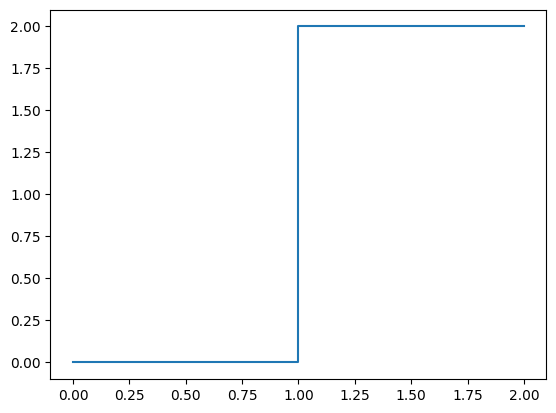

In [22]:
graph(res, 'P1')

```events```列表记录了等待和通信的过程：

In [23]:
events

['delay 1', 'IO ch 2', 'delay 1', 'deadlock']

下面的例子在P0计数，并将每个数的平方传输给P1：

In [24]:
res, events = run_processes({
    'P0': "x := 0; {x := x + 1; ch!x*x; wait(1);}*",
    'P1': "{ch?y;}*"
}, 10, output=["x", "y"])

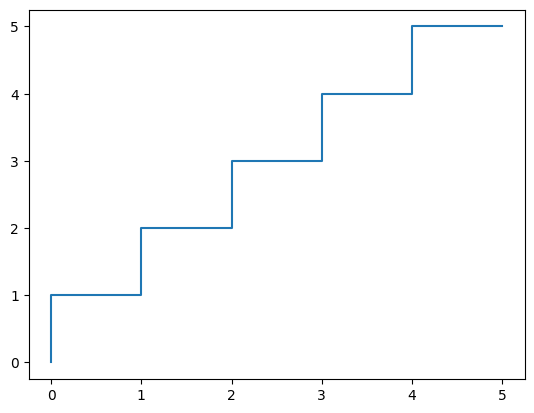

In [25]:
graph(res, 'P0')

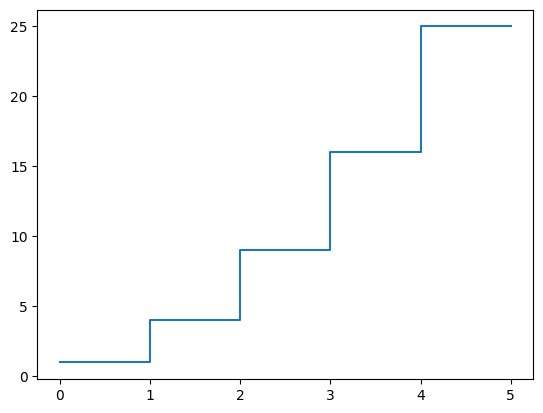

In [26]:
graph(res, 'P1')

In [27]:
events

['IO ch 1',
 'delay 1',
 'IO ch 4',
 'delay 1',
 'IO ch 9',
 'delay 1',
 'IO ch 16',
 'delay 1',
 'IO ch 25',
 'delay 1']

通过结合微分方程、通信和循环，我们已经能够对一些简单控制策略进行建模。以下展示了一个基本的例子。第一个进程代表被控制的物理过程(plant)，第二个进程代表控制策略(control)。每当$x$大于$0.5$时，将速度设为$-1$。每当$x$小于$0.5$时，将速度设为1。这保证了$x$的值能够稳定在$0.5$周围。注意$t$的使用，保证每0.05秒进行一次控制。

In [28]:
res, events = run_processes({
    'P0': "x := 0; v := 1; {t := 0; {x_dot = v, t_dot = 1 & t < 0.05} p2c!x; c2p?v;}*",
    'P1': "{p2c?x; if (x > 0.5) {c2p!-1;} else {c2p!1;}}*"
}, 60, output=["x"])

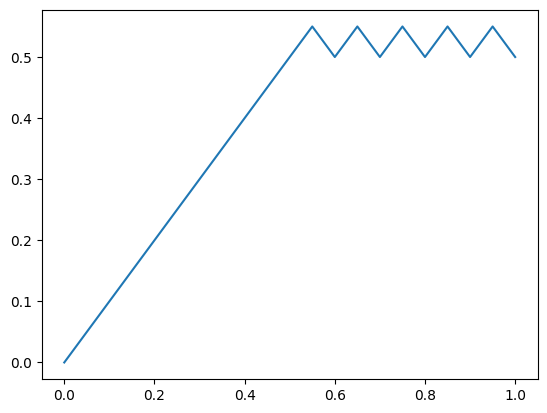

In [29]:
graph(res, 'P0', variables=['x'])

## 中断

HCSP中最复杂的语句合并了微分方程和通讯。在这里$\langle \dot{x}=e \& B\rangle \unrhd [] (ch?x \rightarrow P)$表示根据微分方程$\dot{x}=e$演化，直到状态离开区域$B$，*或者*$ch?x$通讯可以发生。当然，微分方程也可以被输出时间可以发生中断，或者由多个通讯事件中断。

我们先看一个输入事件的例子：

In [30]:
res, events = run_processes({
    'P0': "x := 0; {x_dot = 1 & true} |> [](ch?x --> x := x + 1;) wait(1);",
    'P1': "wait(1); ch!2;"
}, 10, output=["x"])

在这个并发程序中，P0将$x$初始化为0，然后根据微分方程$\dot{x}=1$演化，同时等待来自通道$ch$的输入。进程P1在等待一秒之后可以在$ch$上输出2。因此，通讯在一秒钟之后发生，传输值为2。P0在接收2之后将其存放在$x$里，然后执行$x:=x+1$，因此将$x$设为3。下图展示了仿真结果。

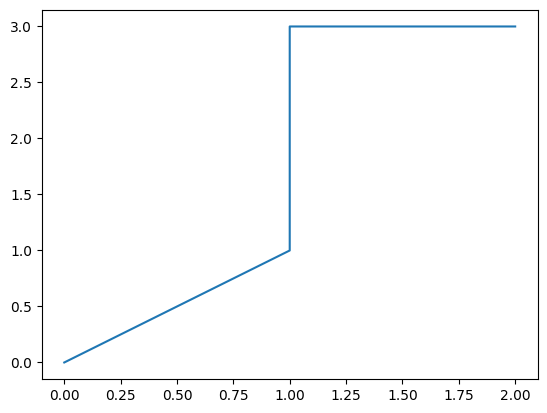

In [31]:
graph(res, 'P0')

下面我们看一个结合中断和循环的例子。第一个进程将$x$初始化为0之后，设$x$的导数为1，然后等待从p2c通道发送$x$的值。从p2c通道发送通信之后，等待从c2p通道接收新的$x$的值。第二个进程等待1秒之后从p2c通道接收通信，并把接收的值存在$x$中，然后发送$x-1$的值。因此这两个进程的并发执行应该为每秒在p2c传递1，然后紧接着在c2p传递0。

In [32]:
res, events = run_processes({
    'P0': "x := 0; {{x_dot = 1 & true} |> [](p2c!x --> skip;) c2p?x;}*",
    'P1': "{wait(1); p2c?x; c2p!x-1;}*"
}, 10, output=["x"])

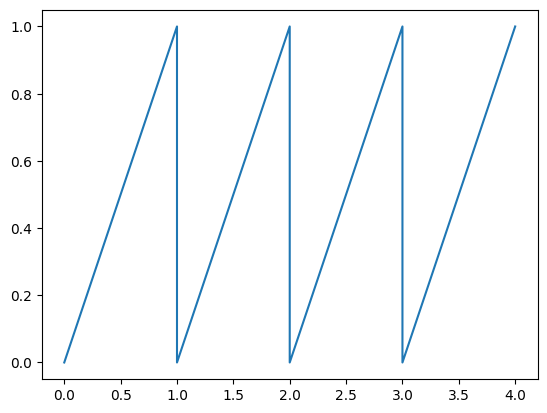

In [33]:
graph(res, 'P0')

下面我们展示一个同时接受两个中断的例子。在这种情况下，首先到达的通信被执行，另一个通信即使到达也不会在本轮执行：

In [34]:
res, events = run_processes({
    'P0': "x := 0; {x_dot = 1 & true} |> [](ch1?x --> skip;, ch2?x --> skip;)",
    'P1': "wait(1); ch2!2; wait(1); ch1!1;"
}, 10, output=["x"])

In [35]:
events

['delay 1', 'IO ch2 2', 'delay 1', 'deadlock']

注意只有第一个到达的$ch2$上的通信执行。第二个通信$ch1$不能匹配，因此系统陷入死锁状态。

当然，我们可以将中断放置在循环中，以接受多个通信：

In [36]:
res, events = run_processes({
    'P0': "x := 0; {{x_dot = 1 & true} |> [](ch1?x --> skip;, ch2?x --> skip;)}*",
    'P1': "wait(1); ch2!2; wait(1); ch1!1; wait(1); ch2!3;"
}, 10, output=["x"])

In [37]:
events

['delay 1',
 'IO ch2 2',
 'delay 1',
 'IO ch1 1',
 'delay 1',
 'IO ch2 3',
 'deadlock']

如果微分方程演化在到达边界之前还没有任何通信，中断语句将退出，任何通信都不会被执行：

In [38]:
res, events = run_processes({
    'P0': "x := 0; {x_dot = 1 & x < 1} |> [](ch?x --> x := x + 1;) wait(2);",
    'P1': "wait(2); ch!2;"
}, 10, output=["x"])

注意$ch$上的通信从未被执行：

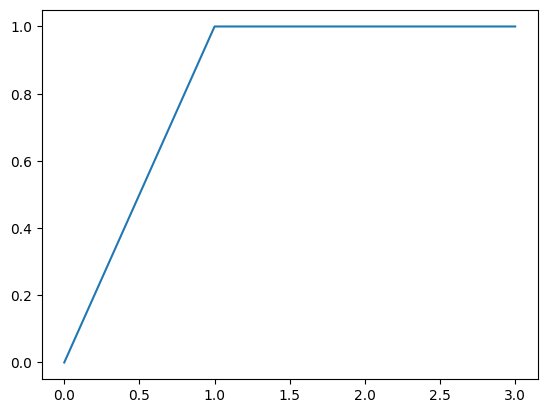

In [39]:
graph(res, 'P0')

In [40]:
events

['delay 1.0', 'delay 1.0', 'delay 1.0', 'deadlock']

中断语句有一个简化版本，不涉及微分方程演化，仅等待一个或多个通信。它的语法和中断的后半部分类似，但把逗号替换为\$符号：

In [41]:
res, events = run_processes({
    'P0': "x := 0; {ch1?x --> skip; $ ch2?x --> skip;}*",
    'P1': "wait(1); ch2!2; wait(1); ch1!1; wait(1); ch2!3;"
}, 10, output=["x"])

In [42]:
events

['delay 1',
 'IO ch2 2',
 'delay 1',
 'IO ch1 1',
 'delay 1',
 'IO ch2 3',
 'deadlock']

In [43]:
res, events = run_processes({
    'P0': "x := 0; {y := uniform(-1,1); t := 0; {x_dot = y, t_dot = 1 & t < 1}}*"
}, 100, output=["x", "y"])

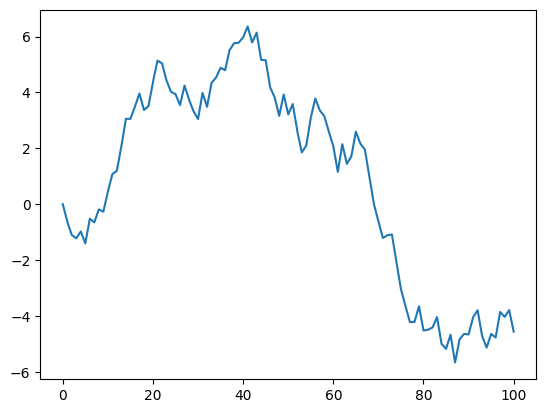

In [44]:
graph(res, 'P0', variables=['x'])

In [45]:
res, events = run_processes({
    'P0': "x := 0; {y := bernoulli(0.7); t := 0; \
                    if (y == 1) {{x_dot = 1, t_dot = 1 & t < 1}} \
                    else {{x_dot = -1, t_dot = 1 & t < 1}}}*"
}, 100, output=["x", "y"])

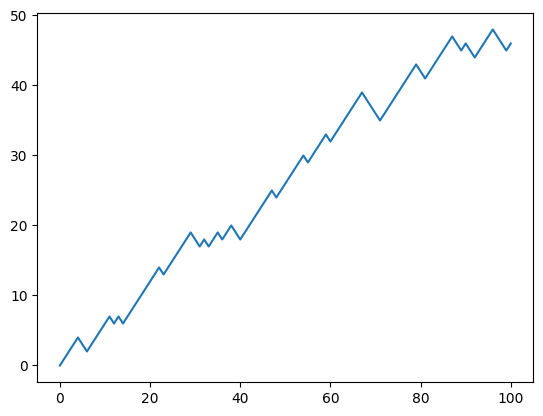

In [46]:
graph(res, 'P0', variables=['x'])

## HCSP的语法

HCSP的语法如下：

$
\begin{array}{lll}
P & ::= &
\mathrm{skip} \mid
x := e \mid
ch?x \mid
ch!e \mid
P; Q \mid
\textrm{if}\ B\ \textrm{then}\ P_1\ \textrm{else}\ P_2 \mid
P \sqcup Q \mid
P^* \mid \\
&& []_{i\in I} (io_i \rightarrow Q_i) \mid
\langle \dot{s}=e \& B \rangle \mid
\langle \dot{s}=e \& B \rangle \unrhd []_{i\in I} (io_i \rightarrow Q_i) \\
S &::=& P \mid S\|_{cs} S
\end{array}
$

其中，$P,Q$和$Q_i$是顺序进程，$S$是并发进程。$x$和$s$是进程中变量的名称，$ch$是通道的名称，$io_i$是通讯事件（输入事件$ch?x$或输出事件$ch!e$），$I$是一个非空的索引集合。$B$和$e$分别是布尔和算术表达式。

每个语句的直观含义如下：

- skip直接终止，不改变状态。
- $x := e$将$x$设为$e$的值，然后终止。
- 输入$ch?x$从通道$ch$接受一个值，并将其赋给变量$x$。该语句可能需要等待输出准备好。
- 输出$ch!e$将$e$的值通过通道$ch$输出。该语句可能需要等待输入准备好。
- $P;Q$指的是先执行$P$，然后执行$Q$。
- 条件语句$\textrm{if}\ B\ \textrm{then}\ P_1\ \textrm{else}\ P_2$的行为如$P_1$如果$B$成立，否则行为如$P_2$。
- 内部选择$P\sqcup Q$的行为可能是$P$或$Q$，由系统自身决定。
- 循环$P^*$执行$P$任意多次。
- 外部选择$[]_{i\in I} (io_i \rightarrow Q_i)$等待通讯$io_i$，并执行第一个发生的通讯，然后执行$Q_i$。
- $\langle \dot{s}=e \& B \rangle$是连续演变的语句，根据微分方程$\dot{s}=e$演变，只要状态满足$B$。我们一般取$B$为一个开集。
- $\langle \dot{s}=e \& B \rangle \unrhd []_{i\in I} (io_i \rightarrow Q_i)$为中断语句，根据微分方程和边界条件演变，但同时等待通讯$io_i$。